# Transfer Learning (Domain Adversarial Training)

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [ ]:
# Download dataset
#!gdown --id '1P4fGNb9JhJj8W0DA_Qrp7mbrRHfF5U_f' --output real_or_drawing.zip
# Unzip the files
!unzip real_or_drawing.zip

Archive:  real_or_drawing.zip
   creating: real_or_drawing/
   creating: real_or_drawing/test_data/
   creating: real_or_drawing/test_data/0/
  inflating: real_or_drawing/test_data/0/00000.bmp  
  inflating: real_or_drawing/test_data/0/00001.bmp  
  inflating: real_or_drawing/test_data/0/00002.bmp  
  inflating: real_or_drawing/test_data/0/00003.bmp  
  inflating: real_or_drawing/test_data/0/00004.bmp  
  inflating: real_or_drawing/test_data/0/00005.bmp  
  inflating: real_or_drawing/test_data/0/00006.bmp  
  inflating: real_or_drawing/test_data/0/00007.bmp  
  inflating: real_or_drawing/test_data/0/00008.bmp  
  inflating: real_or_drawing/test_data/0/00009.bmp  
  inflating: real_or_drawing/test_data/0/00010.bmp  
  inflating: real_or_drawing/test_data/0/00011.bmp  
  inflating: real_or_drawing/test_data/0/00012.bmp  
  inflating: real_or_drawing/test_data/0/00013.bmp  
  inflating: real_or_drawing/test_data/0/00014.bmp  
  inflating: real_or_drawing/test_data/0/00015.bmp  
  inflatin

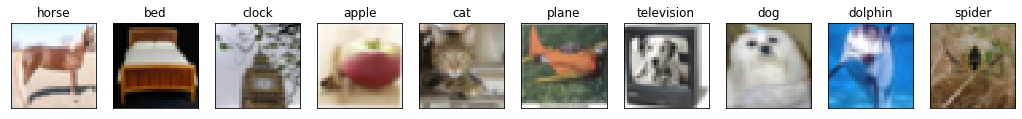

In [1]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

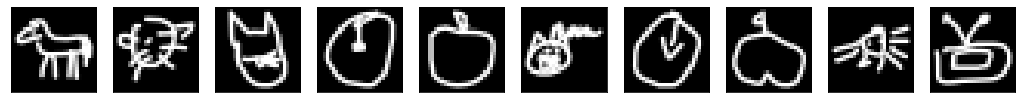

In [2]:
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i+1)
    fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

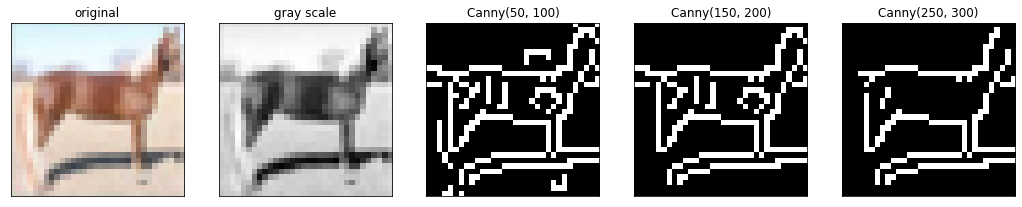

In [4]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')

# Data Process


The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import wandb
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array,
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

In [6]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [7]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [8]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [17]:
wandb.init(project = "Domain Adaption")

In [18]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in tqdm(enumerate(zip(source_dataloader, target_dataloader))):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()

        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# train 200 epochs
for epoch in range(1000):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.3)

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))
    wandb.log({"trD_loss": train_D_loss, "trF_loss": train_F_loss, "tr_acc":train_acc})

0it [00:00, ?it/s]

epoch   0: train D loss: 0.6380, train F loss: -0.1651, acc 0.9926


0it [00:00, ?it/s]

epoch   1: train D loss: 0.6406, train F loss: -0.1561, acc 0.9906


0it [00:00, ?it/s]

epoch   2: train D loss: 0.6387, train F loss: -0.1634, acc 0.9914


0it [00:00, ?it/s]

epoch   3: train D loss: 0.6354, train F loss: -0.1673, acc 0.9936


0it [00:00, ?it/s]

epoch   4: train D loss: 0.6470, train F loss: -0.1708, acc 0.9944


0it [00:00, ?it/s]

epoch   5: train D loss: 0.6428, train F loss: -0.1639, acc 0.9922


0it [00:00, ?it/s]

epoch   6: train D loss: 0.6399, train F loss: -0.1476, acc 0.9880


0it [00:00, ?it/s]

epoch   7: train D loss: 0.6422, train F loss: -0.1636, acc 0.9910


0it [00:00, ?it/s]

epoch   8: train D loss: 0.6438, train F loss: -0.1689, acc 0.9908


0it [00:00, ?it/s]

epoch   9: train D loss: 0.6387, train F loss: -0.1585, acc 0.9922


0it [00:00, ?it/s]

epoch  10: train D loss: 0.6510, train F loss: -0.1633, acc 0.9902


0it [00:00, ?it/s]

epoch  11: train D loss: 0.6426, train F loss: -0.1535, acc 0.9900


0it [00:00, ?it/s]

epoch  12: train D loss: 0.6414, train F loss: -0.1497, acc 0.9882


0it [00:00, ?it/s]

epoch  13: train D loss: 0.6364, train F loss: -0.1611, acc 0.9910


0it [00:00, ?it/s]

epoch  14: train D loss: 0.6367, train F loss: -0.1683, acc 0.9944


0it [00:00, ?it/s]

epoch  15: train D loss: 0.6342, train F loss: -0.1568, acc 0.9898


0it [00:00, ?it/s]

epoch  16: train D loss: 0.6356, train F loss: -0.1667, acc 0.9934


0it [00:00, ?it/s]

epoch  17: train D loss: 0.6370, train F loss: -0.1676, acc 0.9926


0it [00:00, ?it/s]

epoch  18: train D loss: 0.6386, train F loss: -0.1596, acc 0.9916


0it [00:00, ?it/s]

epoch  19: train D loss: 0.6398, train F loss: -0.1566, acc 0.9908


0it [00:00, ?it/s]

epoch  20: train D loss: 0.6438, train F loss: -0.1600, acc 0.9910


0it [00:00, ?it/s]

epoch  21: train D loss: 0.6348, train F loss: -0.1661, acc 0.9938


0it [00:00, ?it/s]

epoch  22: train D loss: 0.6503, train F loss: -0.1574, acc 0.9906


0it [00:00, ?it/s]

epoch  23: train D loss: 0.6376, train F loss: -0.1572, acc 0.9906


0it [00:00, ?it/s]

epoch  24: train D loss: 0.6428, train F loss: -0.1463, acc 0.9868


0it [00:00, ?it/s]

epoch  25: train D loss: 0.6324, train F loss: -0.1645, acc 0.9922


0it [00:00, ?it/s]

epoch  26: train D loss: 0.6420, train F loss: -0.1737, acc 0.9948


0it [00:00, ?it/s]

epoch  27: train D loss: 0.6411, train F loss: -0.1635, acc 0.9928


0it [00:00, ?it/s]

epoch  28: train D loss: 0.6398, train F loss: -0.1691, acc 0.9932


0it [00:00, ?it/s]

epoch  29: train D loss: 0.6353, train F loss: -0.1667, acc 0.9928


0it [00:00, ?it/s]

epoch  30: train D loss: 0.6431, train F loss: -0.1542, acc 0.9880


0it [00:00, ?it/s]

epoch  31: train D loss: 0.6315, train F loss: -0.1583, acc 0.9902


0it [00:00, ?it/s]

epoch  32: train D loss: 0.6281, train F loss: -0.1586, acc 0.9930


0it [00:00, ?it/s]

epoch  33: train D loss: 0.6370, train F loss: -0.1623, acc 0.9918


0it [00:00, ?it/s]

epoch  34: train D loss: 0.6407, train F loss: -0.1675, acc 0.9924


0it [00:00, ?it/s]

epoch  35: train D loss: 0.6378, train F loss: -0.1521, acc 0.9900


0it [00:00, ?it/s]

epoch  36: train D loss: 0.6368, train F loss: -0.1608, acc 0.9902


0it [00:00, ?it/s]

epoch  37: train D loss: 0.6394, train F loss: -0.1627, acc 0.9924


0it [00:00, ?it/s]

epoch  38: train D loss: 0.6489, train F loss: -0.1514, acc 0.9886


0it [00:00, ?it/s]

epoch  39: train D loss: 0.6412, train F loss: -0.1422, acc 0.9872


0it [00:00, ?it/s]

epoch  40: train D loss: 0.6365, train F loss: -0.1661, acc 0.9936


0it [00:00, ?it/s]

epoch  41: train D loss: 0.6340, train F loss: -0.1619, acc 0.9908


0it [00:00, ?it/s]

epoch  42: train D loss: 0.6383, train F loss: -0.1631, acc 0.9922


0it [00:00, ?it/s]

epoch  43: train D loss: 0.6337, train F loss: -0.1543, acc 0.9908


0it [00:00, ?it/s]

epoch  44: train D loss: 0.6321, train F loss: -0.1444, acc 0.9908


0it [00:00, ?it/s]

epoch  45: train D loss: 0.6347, train F loss: -0.1541, acc 0.9874


0it [00:00, ?it/s]

epoch  46: train D loss: 0.6374, train F loss: -0.1649, acc 0.9916


0it [00:00, ?it/s]

epoch  47: train D loss: 0.6355, train F loss: -0.1654, acc 0.9922


0it [00:00, ?it/s]

epoch  48: train D loss: 0.6357, train F loss: -0.1629, acc 0.9914


0it [00:00, ?it/s]

epoch  49: train D loss: 0.6260, train F loss: -0.1618, acc 0.9934


0it [00:00, ?it/s]

epoch  50: train D loss: 0.6412, train F loss: -0.1615, acc 0.9922


0it [00:00, ?it/s]

epoch  51: train D loss: 0.6311, train F loss: -0.1585, acc 0.9902


0it [00:00, ?it/s]

epoch  52: train D loss: 0.6374, train F loss: -0.1712, acc 0.9940


0it [00:00, ?it/s]

epoch  53: train D loss: 0.6304, train F loss: -0.1698, acc 0.9952


0it [00:00, ?it/s]

epoch  54: train D loss: 0.6434, train F loss: -0.1690, acc 0.9920


0it [00:00, ?it/s]

epoch  55: train D loss: 0.6360, train F loss: -0.1682, acc 0.9934


0it [00:00, ?it/s]

epoch  56: train D loss: 0.6370, train F loss: -0.1644, acc 0.9914


0it [00:00, ?it/s]

epoch  57: train D loss: 0.6429, train F loss: -0.1620, acc 0.9914


0it [00:00, ?it/s]

epoch  58: train D loss: 0.6452, train F loss: -0.1595, acc 0.9888


0it [00:00, ?it/s]

epoch  59: train D loss: 0.6313, train F loss: -0.1586, acc 0.9930


0it [00:00, ?it/s]

epoch  60: train D loss: 0.6487, train F loss: -0.1700, acc 0.9922


0it [00:00, ?it/s]

epoch  61: train D loss: 0.6482, train F loss: -0.1432, acc 0.9892


0it [00:00, ?it/s]

epoch  62: train D loss: 0.6404, train F loss: -0.1666, acc 0.9916


0it [00:00, ?it/s]

epoch  63: train D loss: 0.6479, train F loss: -0.1543, acc 0.9882


0it [00:00, ?it/s]

epoch  64: train D loss: 0.6330, train F loss: -0.1680, acc 0.9934


0it [00:00, ?it/s]

epoch  65: train D loss: 0.6382, train F loss: -0.1670, acc 0.9934


0it [00:00, ?it/s]

epoch  66: train D loss: 0.6439, train F loss: -0.1599, acc 0.9910


0it [00:00, ?it/s]

epoch  67: train D loss: 0.6363, train F loss: -0.1593, acc 0.9902


0it [00:00, ?it/s]

epoch  68: train D loss: 0.6371, train F loss: -0.1632, acc 0.9920


0it [00:00, ?it/s]

epoch  69: train D loss: 0.6341, train F loss: -0.1607, acc 0.9918


0it [00:00, ?it/s]

epoch  70: train D loss: 0.6382, train F loss: -0.1456, acc 0.9872


0it [00:00, ?it/s]

epoch  71: train D loss: 0.6367, train F loss: -0.1656, acc 0.9918


0it [00:00, ?it/s]

epoch  72: train D loss: 0.6357, train F loss: -0.1609, acc 0.9924


0it [00:00, ?it/s]

epoch  73: train D loss: 0.6388, train F loss: -0.1568, acc 0.9904


0it [00:00, ?it/s]

epoch  74: train D loss: 0.6383, train F loss: -0.1586, acc 0.9916


0it [00:00, ?it/s]

epoch  75: train D loss: 0.6436, train F loss: -0.1678, acc 0.9934


0it [00:00, ?it/s]

epoch  76: train D loss: 0.6379, train F loss: -0.1693, acc 0.9936


0it [00:00, ?it/s]

epoch  77: train D loss: 0.6466, train F loss: -0.1659, acc 0.9920


0it [00:00, ?it/s]

epoch  78: train D loss: 0.6449, train F loss: -0.1631, acc 0.9920


0it [00:00, ?it/s]

epoch  79: train D loss: 0.6381, train F loss: -0.1604, acc 0.9924


0it [00:00, ?it/s]

epoch  80: train D loss: 0.6299, train F loss: -0.1545, acc 0.9900


0it [00:00, ?it/s]

epoch  81: train D loss: 0.6280, train F loss: -0.1639, acc 0.9942


0it [00:00, ?it/s]

epoch  82: train D loss: 0.6328, train F loss: -0.1674, acc 0.9942


0it [00:00, ?it/s]

epoch  83: train D loss: 0.6362, train F loss: -0.1651, acc 0.9938


0it [00:00, ?it/s]

epoch  84: train D loss: 0.6348, train F loss: -0.1547, acc 0.9900


0it [00:00, ?it/s]

epoch  85: train D loss: 0.6303, train F loss: -0.1689, acc 0.9952


0it [00:00, ?it/s]

epoch  86: train D loss: 0.6416, train F loss: -0.1628, acc 0.9912


0it [00:00, ?it/s]

epoch  87: train D loss: 0.6389, train F loss: -0.1674, acc 0.9928


0it [00:00, ?it/s]

epoch  88: train D loss: 0.6454, train F loss: -0.1535, acc 0.9900


0it [00:00, ?it/s]

epoch  89: train D loss: 0.6373, train F loss: -0.1624, acc 0.9910


0it [00:00, ?it/s]

epoch  90: train D loss: 0.6333, train F loss: -0.1558, acc 0.9900


0it [00:00, ?it/s]

epoch  91: train D loss: 0.6427, train F loss: -0.1545, acc 0.9890


0it [00:00, ?it/s]

epoch  92: train D loss: 0.6335, train F loss: -0.1646, acc 0.9918


0it [00:00, ?it/s]

epoch  93: train D loss: 0.6411, train F loss: -0.1646, acc 0.9926


0it [00:00, ?it/s]

epoch  94: train D loss: 0.6415, train F loss: -0.1709, acc 0.9918


0it [00:00, ?it/s]

epoch  95: train D loss: 0.6403, train F loss: -0.1648, acc 0.9922


0it [00:00, ?it/s]

epoch  96: train D loss: 0.6444, train F loss: -0.1704, acc 0.9930


0it [00:00, ?it/s]

epoch  97: train D loss: 0.6378, train F loss: -0.1634, acc 0.9918


0it [00:00, ?it/s]

epoch  98: train D loss: 0.6421, train F loss: -0.1601, acc 0.9908


0it [00:00, ?it/s]

epoch  99: train D loss: 0.6360, train F loss: -0.1572, acc 0.9910


0it [00:00, ?it/s]

epoch 100: train D loss: 0.6203, train F loss: -0.1557, acc 0.9906


0it [00:00, ?it/s]

epoch 101: train D loss: 0.6235, train F loss: -0.1579, acc 0.9928


0it [00:00, ?it/s]

epoch 102: train D loss: 0.6400, train F loss: -0.1589, acc 0.9902


0it [00:00, ?it/s]

epoch 103: train D loss: 0.6327, train F loss: -0.1474, acc 0.9894


0it [00:00, ?it/s]

epoch 104: train D loss: 0.6369, train F loss: -0.1607, acc 0.9910


0it [00:00, ?it/s]

epoch 105: train D loss: 0.6368, train F loss: -0.1557, acc 0.9896


0it [00:00, ?it/s]

epoch 106: train D loss: 0.6373, train F loss: -0.1704, acc 0.9940


0it [00:00, ?it/s]

epoch 107: train D loss: 0.6382, train F loss: -0.1621, acc 0.9906


0it [00:00, ?it/s]

epoch 108: train D loss: 0.6395, train F loss: -0.1546, acc 0.9922


0it [00:00, ?it/s]

epoch 109: train D loss: 0.6391, train F loss: -0.1517, acc 0.9886


0it [00:00, ?it/s]

epoch 110: train D loss: 0.6358, train F loss: -0.1589, acc 0.9912


0it [00:00, ?it/s]

epoch 111: train D loss: 0.6290, train F loss: -0.1587, acc 0.9916


0it [00:00, ?it/s]

epoch 112: train D loss: 0.6300, train F loss: -0.1601, acc 0.9928


0it [00:00, ?it/s]

epoch 113: train D loss: 0.6352, train F loss: -0.1511, acc 0.9898


0it [00:00, ?it/s]

epoch 114: train D loss: 0.6384, train F loss: -0.1631, acc 0.9910


0it [00:00, ?it/s]

epoch 115: train D loss: 0.6335, train F loss: -0.1704, acc 0.9944


0it [00:00, ?it/s]

epoch 116: train D loss: 0.6320, train F loss: -0.1522, acc 0.9902


0it [00:00, ?it/s]

epoch 117: train D loss: 0.6388, train F loss: -0.1684, acc 0.9932


0it [00:00, ?it/s]

epoch 118: train D loss: 0.6405, train F loss: -0.1718, acc 0.9934


0it [00:00, ?it/s]

epoch 119: train D loss: 0.6413, train F loss: -0.1672, acc 0.9932


0it [00:00, ?it/s]

epoch 120: train D loss: 0.6425, train F loss: -0.1557, acc 0.9904


0it [00:00, ?it/s]

epoch 121: train D loss: 0.6331, train F loss: -0.1676, acc 0.9932


0it [00:00, ?it/s]

epoch 122: train D loss: 0.6339, train F loss: -0.1557, acc 0.9894


0it [00:00, ?it/s]

epoch 123: train D loss: 0.6391, train F loss: -0.1605, acc 0.9908


0it [00:00, ?it/s]

epoch 124: train D loss: 0.6302, train F loss: -0.1612, acc 0.9924


0it [00:00, ?it/s]

epoch 125: train D loss: 0.6418, train F loss: -0.1553, acc 0.9912


0it [00:00, ?it/s]

epoch 126: train D loss: 0.6451, train F loss: -0.1473, acc 0.9882


0it [00:00, ?it/s]

epoch 127: train D loss: 0.6393, train F loss: -0.1679, acc 0.9932


0it [00:00, ?it/s]

epoch 128: train D loss: 0.6362, train F loss: -0.1608, acc 0.9912


0it [00:00, ?it/s]

epoch 129: train D loss: 0.6379, train F loss: -0.1445, acc 0.9882


0it [00:00, ?it/s]

epoch 130: train D loss: 0.6327, train F loss: -0.1607, acc 0.9916


0it [00:00, ?it/s]

epoch 131: train D loss: 0.6397, train F loss: -0.1649, acc 0.9916


0it [00:00, ?it/s]

epoch 132: train D loss: 0.6349, train F loss: -0.1680, acc 0.9930


0it [00:00, ?it/s]

epoch 133: train D loss: 0.6340, train F loss: -0.1638, acc 0.9922


0it [00:00, ?it/s]

epoch 134: train D loss: 0.6367, train F loss: -0.1606, acc 0.9930


0it [00:00, ?it/s]

epoch 135: train D loss: 0.6272, train F loss: -0.1666, acc 0.9934


0it [00:00, ?it/s]

epoch 136: train D loss: 0.6350, train F loss: -0.1490, acc 0.9888


0it [00:00, ?it/s]

epoch 137: train D loss: 0.6395, train F loss: -0.1670, acc 0.9924


0it [00:00, ?it/s]

epoch 138: train D loss: 0.6374, train F loss: -0.1586, acc 0.9892


0it [00:00, ?it/s]

epoch 139: train D loss: 0.6370, train F loss: -0.1457, acc 0.9876


0it [00:00, ?it/s]

epoch 140: train D loss: 0.6181, train F loss: -0.1356, acc 0.9878


0it [00:00, ?it/s]

epoch 141: train D loss: 0.6327, train F loss: -0.1417, acc 0.9884


0it [00:00, ?it/s]

epoch 142: train D loss: 0.6150, train F loss: -0.1585, acc 0.9922


0it [00:00, ?it/s]

epoch 143: train D loss: 0.6315, train F loss: -0.1557, acc 0.9922


0it [00:00, ?it/s]

epoch 144: train D loss: 0.6319, train F loss: -0.1676, acc 0.9948


0it [00:00, ?it/s]

epoch 145: train D loss: 0.6326, train F loss: -0.1606, acc 0.9928


0it [00:00, ?it/s]

epoch 146: train D loss: 0.6343, train F loss: -0.1600, acc 0.9918


0it [00:00, ?it/s]

epoch 147: train D loss: 0.6294, train F loss: -0.1665, acc 0.9924


0it [00:00, ?it/s]

epoch 148: train D loss: 0.6302, train F loss: -0.1631, acc 0.9932


0it [00:00, ?it/s]

epoch 149: train D loss: 0.6256, train F loss: -0.1469, acc 0.9900


0it [00:00, ?it/s]

epoch 150: train D loss: 0.6267, train F loss: -0.1463, acc 0.9890


0it [00:00, ?it/s]

epoch 151: train D loss: 0.6286, train F loss: -0.1610, acc 0.9922


0it [00:00, ?it/s]

epoch 152: train D loss: 0.6283, train F loss: -0.1694, acc 0.9940


0it [00:00, ?it/s]

epoch 153: train D loss: 0.6351, train F loss: -0.1697, acc 0.9946


0it [00:00, ?it/s]

epoch 154: train D loss: 0.6359, train F loss: -0.1743, acc 0.9950


0it [00:00, ?it/s]

epoch 155: train D loss: 0.6451, train F loss: -0.1758, acc 0.9948


0it [00:00, ?it/s]

epoch 156: train D loss: 0.6369, train F loss: -0.1622, acc 0.9914


0it [00:00, ?it/s]

epoch 157: train D loss: 0.6381, train F loss: -0.1589, acc 0.9918


0it [00:00, ?it/s]

epoch 158: train D loss: 0.6372, train F loss: -0.1613, acc 0.9916


0it [00:00, ?it/s]

epoch 159: train D loss: 0.6306, train F loss: -0.1618, acc 0.9928


0it [00:00, ?it/s]

epoch 160: train D loss: 0.6404, train F loss: -0.1549, acc 0.9896


0it [00:00, ?it/s]

epoch 161: train D loss: 0.6393, train F loss: -0.1578, acc 0.9906


0it [00:00, ?it/s]

epoch 162: train D loss: 0.6343, train F loss: -0.1609, acc 0.9916


0it [00:00, ?it/s]

epoch 163: train D loss: 0.6419, train F loss: -0.1642, acc 0.9920


0it [00:00, ?it/s]

epoch 164: train D loss: 0.6391, train F loss: -0.1672, acc 0.9922


0it [00:00, ?it/s]

epoch 165: train D loss: 0.6401, train F loss: -0.1701, acc 0.9928


0it [00:00, ?it/s]

epoch 166: train D loss: 0.6325, train F loss: -0.1651, acc 0.9932


0it [00:00, ?it/s]

epoch 167: train D loss: 0.6389, train F loss: -0.1661, acc 0.9926


0it [00:00, ?it/s]

epoch 168: train D loss: 0.6399, train F loss: -0.1453, acc 0.9878


0it [00:00, ?it/s]

epoch 169: train D loss: 0.6317, train F loss: -0.1685, acc 0.9952


0it [00:00, ?it/s]

epoch 170: train D loss: 0.6315, train F loss: -0.1689, acc 0.9936


0it [00:00, ?it/s]

epoch 171: train D loss: 0.6388, train F loss: -0.1632, acc 0.9914


0it [00:00, ?it/s]

epoch 172: train D loss: 0.6481, train F loss: -0.1617, acc 0.9896


0it [00:00, ?it/s]

epoch 173: train D loss: 0.6299, train F loss: -0.1683, acc 0.9948


0it [00:00, ?it/s]

epoch 174: train D loss: 0.6349, train F loss: -0.1689, acc 0.9940


0it [00:00, ?it/s]

epoch 175: train D loss: 0.6411, train F loss: -0.1631, acc 0.9910


0it [00:00, ?it/s]

epoch 176: train D loss: 0.6397, train F loss: -0.1686, acc 0.9930


0it [00:00, ?it/s]

epoch 177: train D loss: 0.6381, train F loss: -0.1753, acc 0.9960


0it [00:00, ?it/s]

epoch 178: train D loss: 0.6380, train F loss: -0.1580, acc 0.9906


0it [00:00, ?it/s]

epoch 179: train D loss: 0.6381, train F loss: -0.1740, acc 0.9950


0it [00:00, ?it/s]

epoch 180: train D loss: 0.6438, train F loss: -0.1594, acc 0.9926


0it [00:00, ?it/s]

epoch 181: train D loss: 0.6458, train F loss: -0.1659, acc 0.9914


0it [00:00, ?it/s]

epoch 182: train D loss: 0.6409, train F loss: -0.1615, acc 0.9918


0it [00:00, ?it/s]

epoch 183: train D loss: 0.6367, train F loss: -0.1674, acc 0.9940


0it [00:00, ?it/s]

epoch 184: train D loss: 0.6477, train F loss: -0.1626, acc 0.9906


0it [00:00, ?it/s]

epoch 185: train D loss: 0.6360, train F loss: -0.1579, acc 0.9916


0it [00:00, ?it/s]

epoch 186: train D loss: 0.6356, train F loss: -0.1455, acc 0.9874


0it [00:00, ?it/s]

epoch 187: train D loss: 0.6380, train F loss: -0.1581, acc 0.9902


0it [00:00, ?it/s]

epoch 188: train D loss: 0.6371, train F loss: -0.1572, acc 0.9910


0it [00:00, ?it/s]

epoch 189: train D loss: 0.6341, train F loss: -0.1615, acc 0.9926


0it [00:00, ?it/s]

epoch 190: train D loss: 0.6449, train F loss: -0.1712, acc 0.9934


0it [00:00, ?it/s]

epoch 191: train D loss: 0.6377, train F loss: -0.1684, acc 0.9934


0it [00:00, ?it/s]

epoch 192: train D loss: 0.6382, train F loss: -0.1467, acc 0.9900


0it [00:00, ?it/s]

epoch 193: train D loss: 0.6332, train F loss: -0.1623, acc 0.9910


0it [00:00, ?it/s]

epoch 194: train D loss: 0.6366, train F loss: -0.1641, acc 0.9926


0it [00:00, ?it/s]

epoch 195: train D loss: 0.6344, train F loss: -0.1523, acc 0.9904


0it [00:00, ?it/s]

epoch 196: train D loss: 0.6344, train F loss: -0.1653, acc 0.9914


0it [00:00, ?it/s]

epoch 197: train D loss: 0.6327, train F loss: -0.1712, acc 0.9952


0it [00:00, ?it/s]

epoch 198: train D loss: 0.6326, train F loss: -0.1643, acc 0.9948


0it [00:00, ?it/s]

epoch 199: train D loss: 0.6375, train F loss: -0.1670, acc 0.9930


0it [00:00, ?it/s]

epoch 200: train D loss: 0.6385, train F loss: -0.1611, acc 0.9922


0it [00:00, ?it/s]

epoch 201: train D loss: 0.6401, train F loss: -0.1631, acc 0.9932


0it [00:00, ?it/s]

epoch 202: train D loss: 0.6325, train F loss: -0.1597, acc 0.9900


0it [00:00, ?it/s]

epoch 203: train D loss: 0.6351, train F loss: -0.1646, acc 0.9922


0it [00:00, ?it/s]

epoch 204: train D loss: 0.6396, train F loss: -0.1737, acc 0.9950


0it [00:00, ?it/s]

epoch 205: train D loss: 0.6331, train F loss: -0.1766, acc 0.9960


0it [00:00, ?it/s]

epoch 206: train D loss: 0.6494, train F loss: -0.1605, acc 0.9918


0it [00:00, ?it/s]

epoch 207: train D loss: 0.6412, train F loss: -0.1432, acc 0.9868


0it [00:00, ?it/s]

epoch 208: train D loss: 0.6367, train F loss: -0.1681, acc 0.9930


0it [00:00, ?it/s]

epoch 209: train D loss: 0.6347, train F loss: -0.1600, acc 0.9928


0it [00:00, ?it/s]

epoch 210: train D loss: 0.6368, train F loss: -0.1663, acc 0.9928


0it [00:00, ?it/s]

epoch 211: train D loss: 0.6339, train F loss: -0.1628, acc 0.9938


0it [00:00, ?it/s]

epoch 212: train D loss: 0.6468, train F loss: -0.1591, acc 0.9910


0it [00:00, ?it/s]

epoch 213: train D loss: 0.6392, train F loss: -0.1633, acc 0.9912


0it [00:00, ?it/s]

epoch 214: train D loss: 0.6386, train F loss: -0.1617, acc 0.9914


0it [00:00, ?it/s]

epoch 215: train D loss: 0.6383, train F loss: -0.1670, acc 0.9938


0it [00:00, ?it/s]

epoch 216: train D loss: 0.6356, train F loss: -0.1674, acc 0.9940


0it [00:00, ?it/s]

epoch 217: train D loss: 0.6462, train F loss: -0.1621, acc 0.9902


0it [00:00, ?it/s]

epoch 218: train D loss: 0.6378, train F loss: -0.1704, acc 0.9926


0it [00:00, ?it/s]

epoch 219: train D loss: 0.6392, train F loss: -0.1663, acc 0.9912


0it [00:00, ?it/s]

epoch 220: train D loss: 0.6425, train F loss: -0.1676, acc 0.9932


0it [00:00, ?it/s]

epoch 221: train D loss: 0.6439, train F loss: -0.1647, acc 0.9918


0it [00:00, ?it/s]

epoch 222: train D loss: 0.6365, train F loss: -0.1663, acc 0.9930


0it [00:00, ?it/s]

epoch 223: train D loss: 0.6376, train F loss: -0.1590, acc 0.9908


0it [00:00, ?it/s]

epoch 224: train D loss: 0.6401, train F loss: -0.1656, acc 0.9932


0it [00:00, ?it/s]

epoch 225: train D loss: 0.6387, train F loss: -0.1617, acc 0.9916


0it [00:00, ?it/s]

epoch 226: train D loss: 0.6422, train F loss: -0.1662, acc 0.9934


0it [00:00, ?it/s]

epoch 227: train D loss: 0.6450, train F loss: -0.1624, acc 0.9932


0it [00:00, ?it/s]

epoch 228: train D loss: 0.6466, train F loss: -0.1728, acc 0.9942


0it [00:00, ?it/s]

epoch 229: train D loss: 0.6434, train F loss: -0.1333, acc 0.9872


0it [00:00, ?it/s]

epoch 230: train D loss: 0.6400, train F loss: -0.1495, acc 0.9884


0it [00:00, ?it/s]

epoch 231: train D loss: 0.6330, train F loss: -0.1563, acc 0.9918


0it [00:00, ?it/s]

epoch 232: train D loss: 0.6376, train F loss: -0.1545, acc 0.9880


0it [00:00, ?it/s]

epoch 233: train D loss: 0.6323, train F loss: -0.1643, acc 0.9936


0it [00:00, ?it/s]

epoch 234: train D loss: 0.6320, train F loss: -0.1642, acc 0.9932


0it [00:00, ?it/s]

epoch 235: train D loss: 0.6368, train F loss: -0.1621, acc 0.9926


0it [00:00, ?it/s]

epoch 236: train D loss: 0.6410, train F loss: -0.1619, acc 0.9920


0it [00:00, ?it/s]

epoch 237: train D loss: 0.6454, train F loss: -0.1571, acc 0.9902


0it [00:00, ?it/s]

epoch 238: train D loss: 0.6391, train F loss: -0.1696, acc 0.9936


0it [00:00, ?it/s]

epoch 239: train D loss: 0.6349, train F loss: -0.1650, acc 0.9928


0it [00:00, ?it/s]

epoch 240: train D loss: 0.6330, train F loss: -0.1684, acc 0.9942


0it [00:00, ?it/s]

epoch 241: train D loss: 0.6402, train F loss: -0.1637, acc 0.9914


0it [00:00, ?it/s]

epoch 242: train D loss: 0.6402, train F loss: -0.1663, acc 0.9922


0it [00:00, ?it/s]

epoch 243: train D loss: 0.6351, train F loss: -0.1670, acc 0.9958


0it [00:00, ?it/s]

epoch 244: train D loss: 0.6390, train F loss: -0.1550, acc 0.9896


0it [00:00, ?it/s]

epoch 245: train D loss: 0.6336, train F loss: -0.1691, acc 0.9936


0it [00:00, ?it/s]

epoch 246: train D loss: 0.6412, train F loss: -0.1545, acc 0.9900


0it [00:00, ?it/s]

epoch 247: train D loss: 0.6304, train F loss: -0.1676, acc 0.9938


0it [00:00, ?it/s]

epoch 248: train D loss: 0.6388, train F loss: -0.1657, acc 0.9922


0it [00:00, ?it/s]

epoch 249: train D loss: 0.6384, train F loss: -0.1687, acc 0.9940


0it [00:00, ?it/s]

epoch 250: train D loss: 0.6325, train F loss: -0.1688, acc 0.9940


0it [00:00, ?it/s]

epoch 251: train D loss: 0.6429, train F loss: -0.1494, acc 0.9874


0it [00:00, ?it/s]

epoch 252: train D loss: 0.6369, train F loss: -0.1663, acc 0.9932


0it [00:00, ?it/s]

epoch 253: train D loss: 0.6309, train F loss: -0.1705, acc 0.9948


0it [00:00, ?it/s]

epoch 254: train D loss: 0.6375, train F loss: -0.1533, acc 0.9890


0it [00:00, ?it/s]

epoch 255: train D loss: 0.6363, train F loss: -0.1692, acc 0.9938


0it [00:00, ?it/s]

epoch 256: train D loss: 0.6328, train F loss: -0.1685, acc 0.9934


0it [00:00, ?it/s]

epoch 257: train D loss: 0.6382, train F loss: -0.1455, acc 0.9904


0it [00:00, ?it/s]

epoch 258: train D loss: 0.6387, train F loss: -0.1504, acc 0.9900


0it [00:00, ?it/s]

epoch 259: train D loss: 0.6372, train F loss: -0.1719, acc 0.9938


0it [00:00, ?it/s]

epoch 260: train D loss: 0.6408, train F loss: -0.1670, acc 0.9932


0it [00:00, ?it/s]

epoch 261: train D loss: 0.6285, train F loss: -0.1421, acc 0.9906


0it [00:00, ?it/s]

epoch 262: train D loss: 0.6354, train F loss: -0.1641, acc 0.9922


0it [00:00, ?it/s]

epoch 263: train D loss: 0.6419, train F loss: -0.1647, acc 0.9928


0it [00:00, ?it/s]

epoch 264: train D loss: 0.6302, train F loss: -0.1708, acc 0.9946


0it [00:00, ?it/s]

epoch 265: train D loss: 0.6312, train F loss: -0.1594, acc 0.9924


0it [00:00, ?it/s]

epoch 266: train D loss: 0.6347, train F loss: -0.1656, acc 0.9940


0it [00:00, ?it/s]

epoch 267: train D loss: 0.6396, train F loss: -0.1688, acc 0.9934


0it [00:00, ?it/s]

epoch 268: train D loss: 0.6364, train F loss: -0.1694, acc 0.9952


0it [00:00, ?it/s]

epoch 269: train D loss: 0.6354, train F loss: -0.1631, acc 0.9922


0it [00:00, ?it/s]

epoch 270: train D loss: 0.6421, train F loss: -0.1695, acc 0.9940


0it [00:00, ?it/s]

epoch 271: train D loss: 0.6388, train F loss: -0.1618, acc 0.9928


0it [00:00, ?it/s]

epoch 272: train D loss: 0.6361, train F loss: -0.1656, acc 0.9922


0it [00:00, ?it/s]

epoch 273: train D loss: 0.6387, train F loss: -0.1668, acc 0.9930


0it [00:00, ?it/s]

epoch 274: train D loss: 0.6359, train F loss: -0.1655, acc 0.9912


0it [00:00, ?it/s]

epoch 275: train D loss: 0.6329, train F loss: -0.1534, acc 0.9904


0it [00:00, ?it/s]

epoch 276: train D loss: 0.6514, train F loss: -0.1616, acc 0.9908


0it [00:00, ?it/s]

epoch 277: train D loss: 0.6443, train F loss: -0.1727, acc 0.9946


0it [00:00, ?it/s]

epoch 278: train D loss: 0.6364, train F loss: -0.1711, acc 0.9930


0it [00:00, ?it/s]

epoch 279: train D loss: 0.6277, train F loss: -0.1543, acc 0.9906


0it [00:00, ?it/s]

epoch 280: train D loss: 0.6411, train F loss: -0.1674, acc 0.9928


0it [00:00, ?it/s]

epoch 281: train D loss: 0.6402, train F loss: -0.1677, acc 0.9936


0it [00:00, ?it/s]

epoch 282: train D loss: 0.6306, train F loss: -0.1662, acc 0.9936


0it [00:00, ?it/s]

epoch 283: train D loss: 0.6368, train F loss: -0.1613, acc 0.9922


0it [00:00, ?it/s]

epoch 284: train D loss: 0.6302, train F loss: -0.1659, acc 0.9932


0it [00:00, ?it/s]

epoch 285: train D loss: 0.6413, train F loss: -0.1677, acc 0.9926


0it [00:00, ?it/s]

epoch 286: train D loss: 0.6470, train F loss: -0.1570, acc 0.9910


0it [00:00, ?it/s]

epoch 287: train D loss: 0.6410, train F loss: -0.1647, acc 0.9928


0it [00:00, ?it/s]

epoch 288: train D loss: 0.6389, train F loss: -0.1564, acc 0.9896


0it [00:00, ?it/s]

epoch 289: train D loss: 0.6368, train F loss: -0.1702, acc 0.9938


0it [00:00, ?it/s]

epoch 290: train D loss: 0.6405, train F loss: -0.1690, acc 0.9936


0it [00:00, ?it/s]

epoch 291: train D loss: 0.6450, train F loss: -0.1668, acc 0.9926


0it [00:00, ?it/s]

epoch 292: train D loss: 0.6468, train F loss: -0.1697, acc 0.9922


0it [00:00, ?it/s]

epoch 293: train D loss: 0.6350, train F loss: -0.1757, acc 0.9948


0it [00:00, ?it/s]

epoch 294: train D loss: 0.6433, train F loss: -0.1677, acc 0.9932


0it [00:00, ?it/s]

epoch 295: train D loss: 0.6374, train F loss: -0.1654, acc 0.9934


0it [00:00, ?it/s]

epoch 296: train D loss: 0.6428, train F loss: -0.1675, acc 0.9922


0it [00:00, ?it/s]

epoch 297: train D loss: 0.6428, train F loss: -0.1648, acc 0.9914


0it [00:00, ?it/s]

epoch 298: train D loss: 0.6471, train F loss: -0.1695, acc 0.9934


0it [00:00, ?it/s]

epoch 299: train D loss: 0.6435, train F loss: -0.1580, acc 0.9906


0it [00:00, ?it/s]

epoch 300: train D loss: 0.6421, train F loss: -0.1630, acc 0.9926


0it [00:00, ?it/s]

epoch 301: train D loss: 0.6384, train F loss: -0.1569, acc 0.9906


0it [00:00, ?it/s]

epoch 302: train D loss: 0.6389, train F loss: -0.1668, acc 0.9928


0it [00:00, ?it/s]

epoch 303: train D loss: 0.6337, train F loss: -0.1663, acc 0.9928


0it [00:00, ?it/s]

epoch 304: train D loss: 0.6430, train F loss: -0.1563, acc 0.9920


0it [00:00, ?it/s]

epoch 305: train D loss: 0.6468, train F loss: -0.1642, acc 0.9918


0it [00:00, ?it/s]

epoch 306: train D loss: 0.6388, train F loss: -0.1617, acc 0.9912


0it [00:00, ?it/s]

epoch 307: train D loss: 0.6370, train F loss: -0.1728, acc 0.9944


0it [00:00, ?it/s]

epoch 308: train D loss: 0.6415, train F loss: -0.1597, acc 0.9908


0it [00:00, ?it/s]

epoch 309: train D loss: 0.6467, train F loss: -0.1634, acc 0.9914


0it [00:00, ?it/s]

epoch 310: train D loss: 0.6363, train F loss: -0.1671, acc 0.9946


0it [00:00, ?it/s]

epoch 311: train D loss: 0.6408, train F loss: -0.1628, acc 0.9910


0it [00:00, ?it/s]

epoch 312: train D loss: 0.6333, train F loss: -0.1661, acc 0.9934


0it [00:00, ?it/s]

epoch 313: train D loss: 0.6345, train F loss: -0.1675, acc 0.9948


0it [00:00, ?it/s]

epoch 314: train D loss: 0.6441, train F loss: -0.1620, acc 0.9922


0it [00:00, ?it/s]

epoch 315: train D loss: 0.6462, train F loss: -0.1484, acc 0.9896


0it [00:00, ?it/s]

epoch 316: train D loss: 0.6314, train F loss: -0.1616, acc 0.9914


0it [00:00, ?it/s]

epoch 317: train D loss: 0.6369, train F loss: -0.1689, acc 0.9946


0it [00:00, ?it/s]

epoch 318: train D loss: 0.6481, train F loss: -0.1784, acc 0.9954


0it [00:00, ?it/s]

epoch 319: train D loss: 0.6446, train F loss: -0.1691, acc 0.9940


0it [00:00, ?it/s]

epoch 320: train D loss: 0.6330, train F loss: -0.1720, acc 0.9948


0it [00:00, ?it/s]

epoch 321: train D loss: 0.6424, train F loss: -0.1571, acc 0.9910


0it [00:00, ?it/s]

epoch 322: train D loss: 0.6440, train F loss: -0.1617, acc 0.9914


0it [00:00, ?it/s]

epoch 323: train D loss: 0.6419, train F loss: -0.1483, acc 0.9890


0it [00:00, ?it/s]

epoch 324: train D loss: 0.6363, train F loss: -0.1643, acc 0.9936


0it [00:00, ?it/s]

epoch 325: train D loss: 0.6356, train F loss: -0.1698, acc 0.9936


0it [00:00, ?it/s]

epoch 326: train D loss: 0.6489, train F loss: -0.1611, acc 0.9910


0it [00:00, ?it/s]

epoch 327: train D loss: 0.6359, train F loss: -0.1684, acc 0.9938


0it [00:00, ?it/s]

epoch 328: train D loss: 0.6318, train F loss: -0.1574, acc 0.9930


0it [00:00, ?it/s]

epoch 329: train D loss: 0.6412, train F loss: -0.1567, acc 0.9912


0it [00:00, ?it/s]

epoch 330: train D loss: 0.6459, train F loss: -0.1553, acc 0.9880


0it [00:00, ?it/s]

epoch 331: train D loss: 0.6361, train F loss: -0.1589, acc 0.9910


0it [00:00, ?it/s]

epoch 332: train D loss: 0.6333, train F loss: -0.1610, acc 0.9918


0it [00:00, ?it/s]

epoch 333: train D loss: 0.6381, train F loss: -0.1620, acc 0.9930


0it [00:00, ?it/s]

epoch 334: train D loss: 0.6356, train F loss: -0.1723, acc 0.9942


0it [00:00, ?it/s]

epoch 335: train D loss: 0.6346, train F loss: -0.1597, acc 0.9928


0it [00:00, ?it/s]

epoch 336: train D loss: 0.6452, train F loss: -0.1677, acc 0.9934


0it [00:00, ?it/s]

epoch 337: train D loss: 0.6379, train F loss: -0.1693, acc 0.9942


0it [00:00, ?it/s]

epoch 338: train D loss: 0.6343, train F loss: -0.1608, acc 0.9920


0it [00:00, ?it/s]

epoch 339: train D loss: 0.6332, train F loss: -0.1660, acc 0.9930


0it [00:00, ?it/s]

epoch 340: train D loss: 0.6375, train F loss: -0.1572, acc 0.9914


0it [00:00, ?it/s]

epoch 341: train D loss: 0.6390, train F loss: -0.1628, acc 0.9910


0it [00:00, ?it/s]

epoch 342: train D loss: 0.6317, train F loss: -0.1657, acc 0.9934


0it [00:00, ?it/s]

epoch 343: train D loss: 0.6332, train F loss: -0.1692, acc 0.9946


0it [00:00, ?it/s]

epoch 344: train D loss: 0.6316, train F loss: -0.1667, acc 0.9942


0it [00:00, ?it/s]

epoch 345: train D loss: 0.6453, train F loss: -0.1684, acc 0.9934


0it [00:00, ?it/s]

epoch 346: train D loss: 0.6435, train F loss: -0.1708, acc 0.9940


0it [00:00, ?it/s]

epoch 347: train D loss: 0.6430, train F loss: -0.1613, acc 0.9906


0it [00:00, ?it/s]

epoch 348: train D loss: 0.6378, train F loss: -0.1630, acc 0.9938


0it [00:00, ?it/s]

epoch 349: train D loss: 0.6402, train F loss: -0.1435, acc 0.9886


0it [00:00, ?it/s]

epoch 350: train D loss: 0.6375, train F loss: -0.1668, acc 0.9938


0it [00:00, ?it/s]

epoch 351: train D loss: 0.6359, train F loss: -0.1708, acc 0.9950


0it [00:00, ?it/s]

epoch 352: train D loss: 0.6461, train F loss: -0.1667, acc 0.9930


0it [00:00, ?it/s]

epoch 353: train D loss: 0.6446, train F loss: -0.1753, acc 0.9950


0it [00:00, ?it/s]

epoch 354: train D loss: 0.6453, train F loss: -0.1591, acc 0.9912


0it [00:00, ?it/s]

epoch 355: train D loss: 0.6509, train F loss: -0.1682, acc 0.9930


0it [00:00, ?it/s]

epoch 356: train D loss: 0.6349, train F loss: -0.1605, acc 0.9912


0it [00:00, ?it/s]

epoch 357: train D loss: 0.6350, train F loss: -0.1635, acc 0.9942


0it [00:00, ?it/s]

epoch 358: train D loss: 0.6477, train F loss: -0.1691, acc 0.9924


0it [00:00, ?it/s]

epoch 359: train D loss: 0.6417, train F loss: -0.1714, acc 0.9944


0it [00:00, ?it/s]

epoch 360: train D loss: 0.6464, train F loss: -0.1631, acc 0.9896


0it [00:00, ?it/s]

epoch 361: train D loss: 0.6463, train F loss: -0.1658, acc 0.9916


0it [00:00, ?it/s]

epoch 362: train D loss: 0.6443, train F loss: -0.1722, acc 0.9932


0it [00:00, ?it/s]

epoch 363: train D loss: 0.6382, train F loss: -0.1620, acc 0.9914


0it [00:00, ?it/s]

epoch 364: train D loss: 0.6362, train F loss: -0.1566, acc 0.9916


0it [00:00, ?it/s]

epoch 365: train D loss: 0.6338, train F loss: -0.1681, acc 0.9952


0it [00:00, ?it/s]

epoch 366: train D loss: 0.6476, train F loss: -0.1688, acc 0.9922


0it [00:00, ?it/s]

epoch 367: train D loss: 0.6334, train F loss: -0.1701, acc 0.9940


0it [00:00, ?it/s]

epoch 368: train D loss: 0.6328, train F loss: -0.1636, acc 0.9922


0it [00:00, ?it/s]

epoch 369: train D loss: 0.6372, train F loss: -0.1690, acc 0.9930


0it [00:00, ?it/s]

epoch 370: train D loss: 0.6415, train F loss: -0.1596, acc 0.9912


0it [00:00, ?it/s]

epoch 371: train D loss: 0.6373, train F loss: -0.1708, acc 0.9940


0it [00:00, ?it/s]

epoch 372: train D loss: 0.6363, train F loss: -0.1663, acc 0.9930


0it [00:00, ?it/s]

epoch 373: train D loss: 0.6484, train F loss: -0.1732, acc 0.9936


0it [00:00, ?it/s]

epoch 374: train D loss: 0.6410, train F loss: -0.1489, acc 0.9904


0it [00:00, ?it/s]

epoch 375: train D loss: 0.6370, train F loss: -0.1600, acc 0.9928


0it [00:00, ?it/s]

epoch 376: train D loss: 0.6416, train F loss: -0.1645, acc 0.9916


0it [00:00, ?it/s]

epoch 377: train D loss: 0.6277, train F loss: -0.1545, acc 0.9900


0it [00:00, ?it/s]

epoch 378: train D loss: 0.6271, train F loss: -0.1541, acc 0.9900


0it [00:00, ?it/s]

epoch 379: train D loss: 0.6425, train F loss: -0.1671, acc 0.9926


0it [00:00, ?it/s]

epoch 380: train D loss: 0.6320, train F loss: -0.1670, acc 0.9934


0it [00:00, ?it/s]

epoch 381: train D loss: 0.6283, train F loss: -0.1680, acc 0.9940


0it [00:00, ?it/s]

epoch 382: train D loss: 0.6278, train F loss: -0.1636, acc 0.9930


0it [00:00, ?it/s]

epoch 383: train D loss: 0.6378, train F loss: -0.1652, acc 0.9946


0it [00:00, ?it/s]

epoch 384: train D loss: 0.6428, train F loss: -0.1494, acc 0.9888


0it [00:00, ?it/s]

epoch 385: train D loss: 0.6403, train F loss: -0.1679, acc 0.9930


0it [00:00, ?it/s]

epoch 386: train D loss: 0.6363, train F loss: -0.1645, acc 0.9926


0it [00:00, ?it/s]

epoch 387: train D loss: 0.6362, train F loss: -0.1727, acc 0.9960


0it [00:00, ?it/s]

epoch 388: train D loss: 0.6342, train F loss: -0.1690, acc 0.9926


0it [00:00, ?it/s]

epoch 389: train D loss: 0.6458, train F loss: -0.1693, acc 0.9924


0it [00:00, ?it/s]

epoch 390: train D loss: 0.6418, train F loss: -0.1638, acc 0.9928


0it [00:00, ?it/s]

epoch 391: train D loss: 0.6425, train F loss: -0.1679, acc 0.9926


0it [00:00, ?it/s]

epoch 392: train D loss: 0.6422, train F loss: -0.1658, acc 0.9926


0it [00:00, ?it/s]

epoch 393: train D loss: 0.6475, train F loss: -0.1579, acc 0.9904


0it [00:00, ?it/s]

epoch 394: train D loss: 0.6390, train F loss: -0.1730, acc 0.9948


0it [00:00, ?it/s]

epoch 395: train D loss: 0.6373, train F loss: -0.1668, acc 0.9934


0it [00:00, ?it/s]

epoch 396: train D loss: 0.6481, train F loss: -0.1726, acc 0.9952


0it [00:00, ?it/s]

epoch 397: train D loss: 0.6391, train F loss: -0.1745, acc 0.9950


0it [00:00, ?it/s]

epoch 398: train D loss: 0.6481, train F loss: -0.1726, acc 0.9940


0it [00:00, ?it/s]

epoch 399: train D loss: 0.6438, train F loss: -0.1564, acc 0.9896


0it [00:00, ?it/s]

epoch 400: train D loss: 0.6358, train F loss: -0.1542, acc 0.9902


0it [00:00, ?it/s]

epoch 401: train D loss: 0.6443, train F loss: -0.1750, acc 0.9938


0it [00:00, ?it/s]

epoch 402: train D loss: 0.6372, train F loss: -0.1705, acc 0.9946


0it [00:00, ?it/s]

epoch 403: train D loss: 0.6416, train F loss: -0.1727, acc 0.9948


0it [00:00, ?it/s]

epoch 404: train D loss: 0.6327, train F loss: -0.1706, acc 0.9940


0it [00:00, ?it/s]

epoch 405: train D loss: 0.6504, train F loss: -0.1596, acc 0.9916


0it [00:00, ?it/s]

epoch 406: train D loss: 0.6346, train F loss: -0.1701, acc 0.9944


0it [00:00, ?it/s]

epoch 407: train D loss: 0.6466, train F loss: -0.1732, acc 0.9944


0it [00:00, ?it/s]

epoch 408: train D loss: 0.6392, train F loss: -0.1567, acc 0.9914


0it [00:00, ?it/s]

epoch 409: train D loss: 0.6410, train F loss: -0.1535, acc 0.9916


0it [00:00, ?it/s]

epoch 410: train D loss: 0.6435, train F loss: -0.1697, acc 0.9934


0it [00:00, ?it/s]

epoch 411: train D loss: 0.6405, train F loss: -0.1678, acc 0.9932


0it [00:00, ?it/s]

epoch 412: train D loss: 0.6387, train F loss: -0.1523, acc 0.9908


0it [00:00, ?it/s]

epoch 413: train D loss: 0.6443, train F loss: -0.1629, acc 0.9912


0it [00:00, ?it/s]

epoch 414: train D loss: 0.6395, train F loss: -0.1755, acc 0.9954


0it [00:00, ?it/s]

epoch 415: train D loss: 0.6492, train F loss: -0.1715, acc 0.9926


0it [00:00, ?it/s]

epoch 416: train D loss: 0.6469, train F loss: -0.1713, acc 0.9934


0it [00:00, ?it/s]

epoch 417: train D loss: 0.6515, train F loss: -0.1646, acc 0.9920


0it [00:00, ?it/s]

epoch 418: train D loss: 0.6455, train F loss: -0.1520, acc 0.9894


0it [00:00, ?it/s]

epoch 419: train D loss: 0.6375, train F loss: -0.1700, acc 0.9934


0it [00:00, ?it/s]

epoch 420: train D loss: 0.6445, train F loss: -0.1648, acc 0.9924


0it [00:00, ?it/s]

epoch 421: train D loss: 0.6391, train F loss: -0.1684, acc 0.9934


0it [00:00, ?it/s]

epoch 422: train D loss: 0.6449, train F loss: -0.1732, acc 0.9936


0it [00:00, ?it/s]

epoch 423: train D loss: 0.6454, train F loss: -0.1683, acc 0.9922


0it [00:00, ?it/s]

epoch 424: train D loss: 0.6435, train F loss: -0.1737, acc 0.9938


0it [00:00, ?it/s]

epoch 425: train D loss: 0.6481, train F loss: -0.1624, acc 0.9908


0it [00:00, ?it/s]

epoch 426: train D loss: 0.6403, train F loss: -0.1714, acc 0.9940


0it [00:00, ?it/s]

epoch 427: train D loss: 0.6442, train F loss: -0.1688, acc 0.9928


0it [00:00, ?it/s]

epoch 428: train D loss: 0.6458, train F loss: -0.1703, acc 0.9944


0it [00:00, ?it/s]

epoch 429: train D loss: 0.6482, train F loss: -0.1729, acc 0.9934


0it [00:00, ?it/s]

epoch 430: train D loss: 0.6489, train F loss: -0.1611, acc 0.9904


0it [00:00, ?it/s]

epoch 431: train D loss: 0.6402, train F loss: -0.1727, acc 0.9940


0it [00:00, ?it/s]

epoch 432: train D loss: 0.6334, train F loss: -0.1663, acc 0.9936


0it [00:00, ?it/s]

epoch 433: train D loss: 0.6465, train F loss: -0.1693, acc 0.9938


0it [00:00, ?it/s]

epoch 434: train D loss: 0.6481, train F loss: -0.1729, acc 0.9940


0it [00:00, ?it/s]

epoch 435: train D loss: 0.6439, train F loss: -0.1611, acc 0.9904


0it [00:00, ?it/s]

epoch 436: train D loss: 0.6443, train F loss: -0.1660, acc 0.9924


0it [00:00, ?it/s]

epoch 437: train D loss: 0.6322, train F loss: -0.1655, acc 0.9938


0it [00:00, ?it/s]

epoch 438: train D loss: 0.6453, train F loss: -0.1516, acc 0.9906


0it [00:00, ?it/s]

epoch 439: train D loss: 0.6451, train F loss: -0.1639, acc 0.9932


0it [00:00, ?it/s]

epoch 440: train D loss: 0.6404, train F loss: -0.1663, acc 0.9930


0it [00:00, ?it/s]

epoch 441: train D loss: 0.6420, train F loss: -0.1754, acc 0.9956


0it [00:00, ?it/s]

epoch 442: train D loss: 0.6423, train F loss: -0.1618, acc 0.9924


0it [00:00, ?it/s]

epoch 443: train D loss: 0.6449, train F loss: -0.1653, acc 0.9914


0it [00:00, ?it/s]

epoch 444: train D loss: 0.6434, train F loss: -0.1714, acc 0.9936


0it [00:00, ?it/s]

epoch 445: train D loss: 0.6472, train F loss: -0.1717, acc 0.9932


0it [00:00, ?it/s]

epoch 446: train D loss: 0.6438, train F loss: -0.1700, acc 0.9930


0it [00:00, ?it/s]

epoch 447: train D loss: 0.6425, train F loss: -0.1666, acc 0.9932


0it [00:00, ?it/s]

epoch 448: train D loss: 0.6397, train F loss: -0.1593, acc 0.9906


0it [00:00, ?it/s]

epoch 449: train D loss: 0.6337, train F loss: -0.1694, acc 0.9932


0it [00:00, ?it/s]

epoch 450: train D loss: 0.6377, train F loss: -0.1685, acc 0.9930


0it [00:00, ?it/s]

epoch 451: train D loss: 0.6445, train F loss: -0.1588, acc 0.9906


0it [00:00, ?it/s]

epoch 452: train D loss: 0.6456, train F loss: -0.1720, acc 0.9948


0it [00:00, ?it/s]

epoch 453: train D loss: 0.6440, train F loss: -0.1711, acc 0.9924


0it [00:00, ?it/s]

epoch 454: train D loss: 0.6387, train F loss: -0.1550, acc 0.9912


0it [00:00, ?it/s]

epoch 455: train D loss: 0.6432, train F loss: -0.1665, acc 0.9922


0it [00:00, ?it/s]

epoch 456: train D loss: 0.6330, train F loss: -0.1657, acc 0.9946


0it [00:00, ?it/s]

epoch 457: train D loss: 0.6356, train F loss: -0.1679, acc 0.9938


0it [00:00, ?it/s]

epoch 458: train D loss: 0.6406, train F loss: -0.1612, acc 0.9906


0it [00:00, ?it/s]

epoch 459: train D loss: 0.6406, train F loss: -0.1724, acc 0.9950


0it [00:00, ?it/s]

epoch 460: train D loss: 0.6473, train F loss: -0.1682, acc 0.9928


0it [00:00, ?it/s]

epoch 461: train D loss: 0.6379, train F loss: -0.1706, acc 0.9942


0it [00:00, ?it/s]

epoch 462: train D loss: 0.6397, train F loss: -0.1744, acc 0.9950


0it [00:00, ?it/s]

epoch 463: train D loss: 0.6406, train F loss: -0.1678, acc 0.9932


0it [00:00, ?it/s]

epoch 464: train D loss: 0.6479, train F loss: -0.1621, acc 0.9910


0it [00:00, ?it/s]

epoch 465: train D loss: 0.6508, train F loss: -0.1413, acc 0.9848


0it [00:00, ?it/s]

epoch 466: train D loss: 0.6437, train F loss: -0.1737, acc 0.9944


0it [00:00, ?it/s]

epoch 467: train D loss: 0.6442, train F loss: -0.1703, acc 0.9944


0it [00:00, ?it/s]

epoch 468: train D loss: 0.6481, train F loss: -0.1689, acc 0.9928


0it [00:00, ?it/s]

epoch 469: train D loss: 0.6410, train F loss: -0.1686, acc 0.9928


0it [00:00, ?it/s]

epoch 470: train D loss: 0.6414, train F loss: -0.1663, acc 0.9924


0it [00:00, ?it/s]

epoch 471: train D loss: 0.6461, train F loss: -0.1750, acc 0.9946


0it [00:00, ?it/s]

epoch 472: train D loss: 0.6460, train F loss: -0.1654, acc 0.9928


0it [00:00, ?it/s]

epoch 473: train D loss: 0.6443, train F loss: -0.1607, acc 0.9912


0it [00:00, ?it/s]

epoch 474: train D loss: 0.6456, train F loss: -0.1738, acc 0.9942


0it [00:00, ?it/s]

epoch 475: train D loss: 0.6409, train F loss: -0.1700, acc 0.9936


0it [00:00, ?it/s]

epoch 476: train D loss: 0.6462, train F loss: -0.1683, acc 0.9928


0it [00:00, ?it/s]

epoch 477: train D loss: 0.6387, train F loss: -0.1679, acc 0.9930


0it [00:00, ?it/s]

epoch 478: train D loss: 0.6313, train F loss: -0.1611, acc 0.9932


0it [00:00, ?it/s]

epoch 479: train D loss: 0.6447, train F loss: -0.1565, acc 0.9890


0it [00:00, ?it/s]

epoch 480: train D loss: 0.6391, train F loss: -0.1701, acc 0.9938


0it [00:00, ?it/s]

epoch 481: train D loss: 0.6483, train F loss: -0.1719, acc 0.9938


0it [00:00, ?it/s]

epoch 482: train D loss: 0.6481, train F loss: -0.1782, acc 0.9954


0it [00:00, ?it/s]

epoch 483: train D loss: 0.6428, train F loss: -0.1725, acc 0.9938


0it [00:00, ?it/s]

epoch 484: train D loss: 0.6447, train F loss: -0.1739, acc 0.9952


0it [00:00, ?it/s]

epoch 485: train D loss: 0.6493, train F loss: -0.1754, acc 0.9942


0it [00:00, ?it/s]

epoch 486: train D loss: 0.6454, train F loss: -0.1693, acc 0.9924


0it [00:00, ?it/s]

epoch 487: train D loss: 0.6470, train F loss: -0.1743, acc 0.9946


0it [00:00, ?it/s]

epoch 488: train D loss: 0.6524, train F loss: -0.1713, acc 0.9930


0it [00:00, ?it/s]

epoch 489: train D loss: 0.6521, train F loss: -0.1616, acc 0.9906


0it [00:00, ?it/s]

epoch 490: train D loss: 0.6475, train F loss: -0.1683, acc 0.9918


0it [00:00, ?it/s]

epoch 491: train D loss: 0.6451, train F loss: -0.1688, acc 0.9924


0it [00:00, ?it/s]

epoch 492: train D loss: 0.6412, train F loss: -0.1727, acc 0.9940


0it [00:00, ?it/s]

epoch 493: train D loss: 0.6511, train F loss: -0.1752, acc 0.9946


0it [00:00, ?it/s]

epoch 494: train D loss: 0.6418, train F loss: -0.1703, acc 0.9936


0it [00:00, ?it/s]

epoch 495: train D loss: 0.6508, train F loss: -0.1637, acc 0.9892


0it [00:00, ?it/s]

epoch 496: train D loss: 0.6367, train F loss: -0.1637, acc 0.9928


0it [00:00, ?it/s]

epoch 497: train D loss: 0.6422, train F loss: -0.1703, acc 0.9934


0it [00:00, ?it/s]

epoch 498: train D loss: 0.6456, train F loss: -0.1648, acc 0.9932


0it [00:00, ?it/s]

epoch 499: train D loss: 0.6492, train F loss: -0.1732, acc 0.9932


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [14]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there are any problem related to Domain Adaptation, please email to b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

The Q&A section might be updated to here if I have time.
